In [1]:
from __future__ import print_function
import pandas as pd
import numpy as np
import os
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import ipysheet
import colorsys
import xlsxwriter
import csv
from tqdm import tqdm_notebook as tqdm
from datetime import datetime
import matplotlib.pyplot as plt
import sys
import itertools
import time
from scipy import signal
from datetime import datetime

In [2]:
# import python CWL files

module_path = os.path.abspath(os.path.join('/SSB'))
if module_path not in sys.path:
    sys.path.append(module_path)

from od_matrices import run, collect_groups, to_groups, plot_od_pixmap, compute_matrix_norms,collect_matrix_entries, generate_hist_plot, generate_bar_plot

module_path = os.path.abspath(os.path.join('../../python/python_src_preprocessing/target_learning'))
if module_path not in sys.path:
    sys.path.append(module_path)

from preprocessing.preprocessing import add_pedestrian_to_field, gaussian_pdf
import plotting.densitymap as densitymap 


# TO-DO's:

- check mean and variance of time series data
- compute difference of density map
- plot density vec 1d
- plot od matrix 1d 


### Methods for computing gauss density

In [3]:
radius = 1 # TODO: This parameter is uncertain
ped_radius = 0.195 # TODO: This parameter is uncertain
signma = 0.7

# TODO: add changes to this method to the pre-processing file
def gauss_filter():
    x_range = np.linspace(-1,1,5)
    xx, yy = np.meshgrid(x_range,x_range, sparse=False)
    grid = np.sqrt(np.square(xx) + np.square(yy))
    gauss = np.vectorize(gaussian_pdf)
    gauss_grid = gauss(signma, grid, ped_radius)
    return gauss_grid

# This method was transfered from vadere java to python
# Adds the position of a pedestrian to a matrix
# pedestrian is split between 4 cells using interpolation
# max value of a pedestran is 1
# position_matrix : 2d matrix containing the positions of every pedestrian (matrix is updated not overwritten)
# x,y : trajectory coordinates for single pedestrian
def mapp_ped_positions(position_matrix, x,y, res):
    lowerLeftX = int((x-1)/res)
    lowerLeftY = int((y-1)/res)
    cordX = x/res
    cordY = y/res
    
    dx = abs(cordX - lowerLeftX)
    dy = abs(cordY - lowerLeftY)
    
    w1 = dx*dy
    w2 = dx*(1-dy)
    w3 = (1-dx)*dy
    w4 = (1-dx)*(1-dy)
    
    if not np.less_equal(np.round(w1+w2+w3+w4,4),1.0):
        print("error w1+w2+w3+w4 should be 1 but is ",w1+w2+w3+w4)
    
    position_matrix[lowerLeftY-1,lowerLeftX-1] += w1
    position_matrix[lowerLeftY, lowerLeftX-1] += w2
    position_matrix[lowerLeftY-1, lowerLeftX] += w3
    position_matrix[lowerLeftY, lowerLeftX] += w4
    
    return position_matrix

def get_od_vector(od,ods_not_considered):
    od_vec = []
    for i in range(-1, od.shape[0]-1):
        for j in range(-1, od.shape[1]-1):
            if [i,j] not in ods_not_considered:
                od_vec.append(od[i+1,j+1])
                
    return od_vec
        

In [4]:
day = "20190906"
base = '/media/veracrypt1/objectstream_{0}/'.format(day)
# 6 7 8 9 10 11 12 13 14 15 16 17 18 19
#new_dir = "csv{0}".format(day)
#if new_dir not in os.listdir(): 
#    os.makedirs(new_dir)
    
ods_not_considered = pd.read_csv(os.path.join(os.getcwd(), 'ods_not_considered.csv'))
ods_not_considered = ods_not_considered.values.tolist()
mapping = pd.read_csv(os.path.join(base, 'mapping_removed.csv'), dtype={'pedestrianId': 'str'})


## Generate Density Maps and OD-Matrices

- OD-matrix every 10s time interval
- Density maps for every 2s in a 10s interval

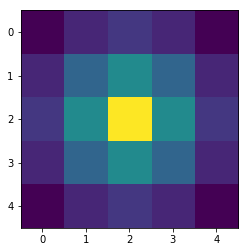

selected hours [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]


In [5]:
# compute gaussian filter
gsfilter = gauss_filter()
plt.imshow(gsfilter)
plt.show()

# maximum domain size
x_offset = 47000
y_offset = 10000
width = 54000 # measurment in mm -> reduced by resolution of res=500
height = 19000 # measurment in mm -> reduced by resolution of res=500

resolution = 500
ped_count_threshold = 50

matrix_size = (height//resolution,width//resolution)

# concaternate all selected hours of one day
hours = list(range(5,22))
print("selected hours",hours)

interval 06, Sep 2019_05:35:10 AM_05:35:16 AM only has 4 subintervals. interval is not added to file.
finished hour 06, Sep 2019_05:59:50 AM_05:59:59 AM
total intervals: 360 Used intervals: 314 Discarded intervals: 46


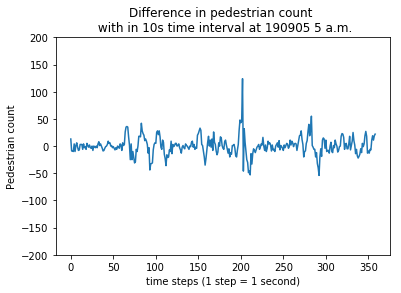

finished hour 06, Sep 2019_06:59:50 AM_06:59:59 AM
total intervals: 360 Used intervals: 324 Discarded intervals: 36


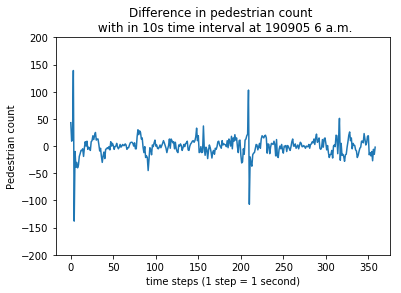

finished hour 06, Sep 2019_07:59:50 AM_07:59:59 AM
total intervals: 360 Used intervals: 263 Discarded intervals: 97


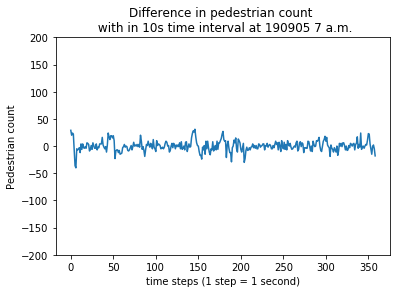

finished hour 06, Sep 2019_08:59:50 AM_08:59:59 AM
total intervals: 360 Used intervals: 345 Discarded intervals: 15


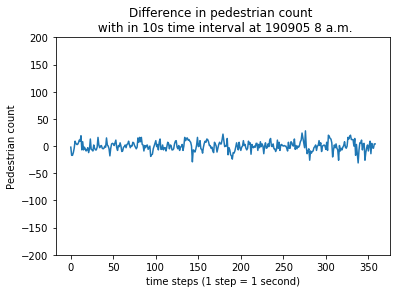

finished hour 06, Sep 2019_09:59:50 AM_09:59:59 AM
total intervals: 360 Used intervals: 295 Discarded intervals: 65


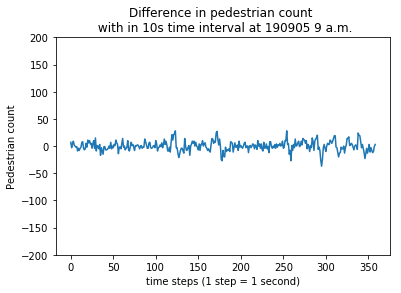

finished hour 06, Sep 2019_10:59:50 AM_10:59:59 AM
total intervals: 360 Used intervals: 357 Discarded intervals: 3


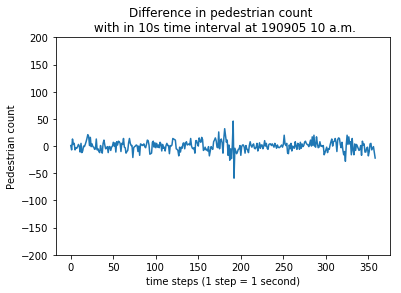

finished hour 06, Sep 2019_11:59:50 AM_11:59:59 AM
total intervals: 360 Used intervals: 354 Discarded intervals: 6


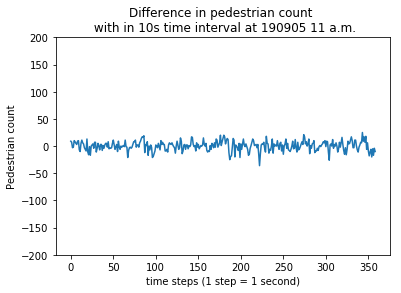

finished hour 06, Sep 2019_12:59:50 PM_12:59:59 PM
total intervals: 360 Used intervals: 355 Discarded intervals: 5


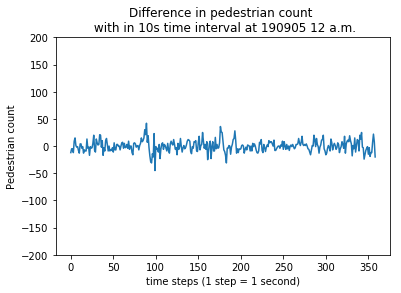

finished hour 06, Sep 2019_01:59:50 PM_01:59:59 PM
total intervals: 360 Used intervals: 354 Discarded intervals: 6


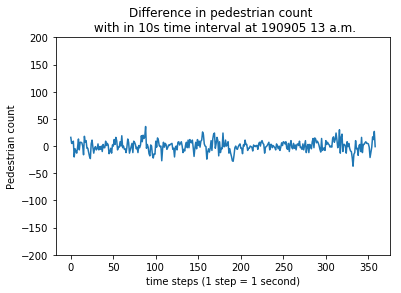

finished hour 06, Sep 2019_02:59:50 PM_02:59:59 PM
total intervals: 360 Used intervals: 354 Discarded intervals: 6


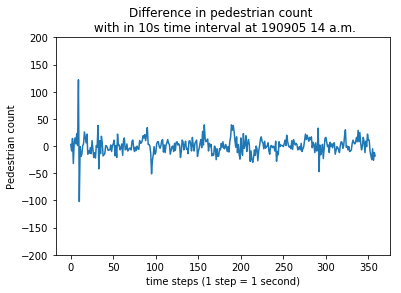

finished hour 06, Sep 2019_03:59:50 PM_03:59:59 PM
total intervals: 360 Used intervals: 351 Discarded intervals: 9


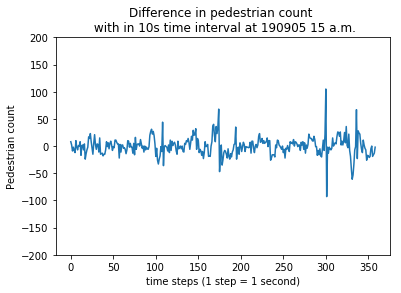

finished hour 06, Sep 2019_04:59:50 PM_04:59:59 PM
total intervals: 360 Used intervals: 353 Discarded intervals: 7


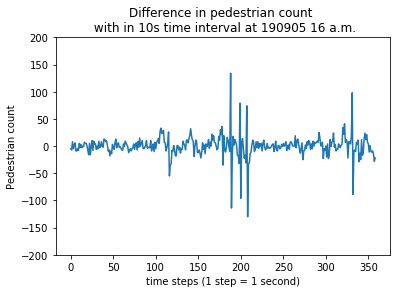

finished hour 06, Sep 2019_05:59:50 PM_05:59:59 PM
total intervals: 360 Used intervals: 257 Discarded intervals: 103


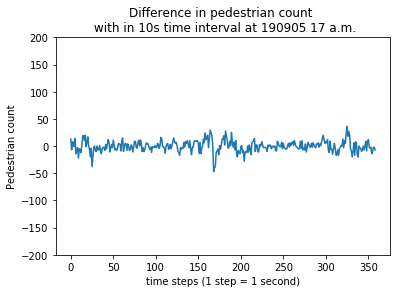

finished hour 06, Sep 2019_06:59:50 PM_06:59:59 PM
total intervals: 360 Used intervals: 218 Discarded intervals: 142


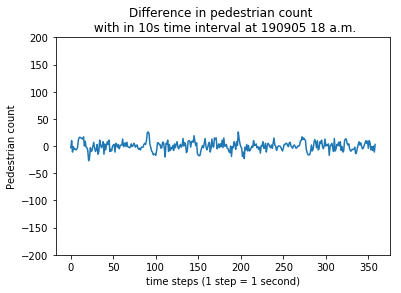

finished hour 06, Sep 2019_07:58:50 PM_07:58:59 PM
total intervals: 360 Used intervals: 176 Discarded intervals: 184


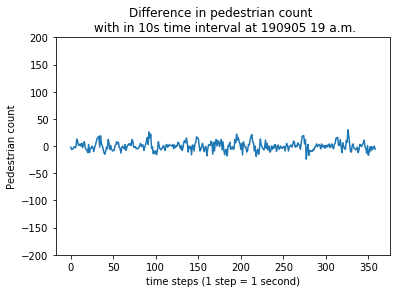

finished hour 06, Sep 2019_08:59:50 PM_08:59:59 PM
total intervals: 360 Used intervals: 117 Discarded intervals: 243


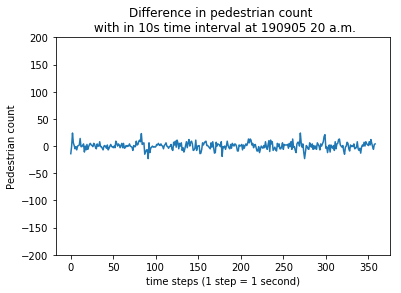

finished hour 06, Sep 2019_09:58:50 PM_09:58:59 PM
total intervals: 360 Used intervals: 48 Discarded intervals: 312


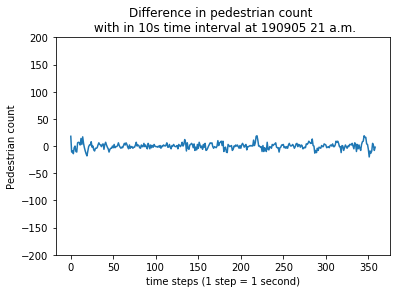

total number of used intervals 4835


In [7]:
total_number_intervals = 0
row_length = 0

for h in hours:
    output_file = open('density_maps-diff-{0}-{1}-{2}.csv'.format(day, h, datetime.now()), 'a', newline='')
    outwriter = csv.writer(output_file, delimiter=',')
    test_output = 0
    # counters
    full_interval = 0
    missing_interval = 0
    pedestian_count = []
    # assertions
    test = True
    # store info
    info_group = [] # store date, start and end times for groups
    info_subgroup = [] # store date, start and end times for subgroups
    
    tick0 = time.time() # measure time to process one hour
    frame = pd.read_csv(os.path.join(base, 'hours', 'hour-{0}.csv'.format(h)), dtype={'pedestrianId': 'str'})
    frame.x = frame.x.add(x_offset) # transform coordinates such that origin is (0,0) at lower left corner 
    frame.y = frame.y.add(y_offset)
    # divide pedestrians into 10s intervals, generate od-matrix
    
    groups, od_matrices, origins_str, destinations_str = collect_groups(frame, mapping, ('S', 10, 1, 0))
    
    for g in range(0,len(groups)): # divide in 10 second intervals
        group = groups[g]
        ped_count = len(group.pedestrianId.unique())
        pedestian_count.append(ped_count)
        
        if ped_count < ped_count_threshold:
            continue
        
        od_vec = get_od_vector(od_matrices[g][2], ods_not_considered)
        start_g = group.datetime.iloc[0]
        end_g = group.datetime.iloc[-1]
        
        sub_groups = to_groups(group, 1, 'S', 1, 0)
        info_group.append('{:%d, %b %Y}_{:%I:%M:%S %p}_{:%I:%M:%S %p}'.format(start_g,start_g,end_g))
        lengths = [len(sub) for sub in sub_groups]

        if 0 in lengths:  # compute density if ped count < threshold and all time steps exist
            continue

        density_maps = []
        
        for s in range(0,len(sub_groups)): # divide in 1 second intervals
            sub_group = sub_groups[s]
            if np.mod(s,2) != 0:
                continue
            
            start_sg = sub_group.datetime.iloc[0]
            end_sg = sub_group.datetime.iloc[-1]
            info_subgroup.append('{:%d, %b %Y}_{:%I:%M:%S %p}'.format(start_sg,start_sg))
            pedestrian_matrix = np.zeros(matrix_size)
            x_cords = sub_group['x'].values.tolist()
            y_cords = sub_group['y'].values.tolist()

            for k in range(0,len(x_cords)):
                pedestrian_matrix = mapp_ped_positions(pedestrian_matrix, x_cords[k],y_cords[k], resolution)

            density_map = signal.convolve2d(pedestrian_matrix,gsfilter, mode='same')
            densit_map = np.round(density_map, 8)
            density_maps.append(density_map.flatten('C'))
        
        # write to file
        if len(density_maps) != 5:
            print("interval", info_group[-1], "only has", len(density_maps), "subintervals. interval is not added to file.")
            continue
        
        # differencing
        density_maps = [np.subtract(density_maps[i],density_maps[i-1]) for i in range(1,len(density_maps))]
        output_data = np.concatenate(density_maps)
        output_data = np.concatenate((output_data, od_vec))
        new_row_length = len(output_data)
        
        # make sure the output data file has same amound of columns in every row
        if row_length > 0 and row_length != new_row_length:
            print("ERROR! row length not equal! Should be", row_length,"but is",new_row_length)
        row_length = new_row_length
        
        outwriter.writerow(output_data)
        full_interval += 1
    
    print("finished hour",info_group[-1])
    print("total intervals: 360","Used intervals:",full_interval, "Discarded intervals:",360-full_interval)
    #print("time intervals with missing time steps", missing_interval)
    total_number_intervals += full_interval
    plt.title("Difference in pedestrian count \n with in 10s time interval at 190905 {0} a.m.".format(h))
    plt.ylabel("Pedestrian count")
    plt.xlabel("time steps (1 step = 1 second)")
    diff_ped_count = [pedestian_count[i]-pedestian_count[i-1] for i in range(1,len(pedestian_count))]
    plt.plot(list(range(0,len(diff_ped_count))),diff_ped_count)
    plt.ylim([-200,200])
    plt.savefig("diff_ped_count_{0}_{1}am.png".format(day,h), dpi=500)
    plt.show()

    output_file.close()
print("total number of used intervals", total_number_intervals)

#### figure showing pedestrian count over selected hours

In [ ]:
test_density = pd.read_csv(os.path.join(os.getcwd(), 'density_maps-20190906-2020-02-02 18:38:11.637288.csv'))

In [ ]:
print(test_density.shape)
test_density.tail()

In [ ]:
#maxx = frame.x.max()
#minx = frame.x.min()
#maxy = frame.y.max()
#miny = frame.y.min()
#print(minx,maxx,miny,maxy)

if test_output == 0:
                plt.imshow(density_map, cmap='rainbow')
                plt.title(info_subgroup[-1])
                #plt.clim(0,0.5)
                print("max val", np.max(density_map))
                plt.colorbar(fraction=0.015, pad=0.04)
                plt.savefig("{0}.png".format(info_subgroup[-1]))
                plt.show()
            
    